# The data

http://archive.ics.uci.edu/ml/datasets/Solar+Flare

Zobaczmy, czy regresja dobrze sprawdzi się w klasyfikacji obszarów na słońcu pod względem występowania różnych klas rozbłysków słonecznych.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn import linear_model, metrics
from pandas import Series
from pandas import DataFrame

import matplotlib.pyplot as plt

In [20]:
train_data = pd.read_csv('flare.data1', sep=' ', names=['class', 'largest-spot', 'spot-distr', 'activity', 'evolution', 'previous', 'historically-complex', 'hconpass', 'area', 'largest-spot-area', 'C-class', 'M-class', 'X-class'])
test_data = pd.read_csv('flare.data2', sep=' ',names=['class', 'largest-spot', 'spot-distr', 'activity', 'evolution', 'previous', 'historically-complex', 'hconpass', 'area', 'largest-spot-area', 'C-class', 'M-class', 'X-class'])

In [21]:
train_data.head()

,class,largest-spot,spot-distr,activity,evolution,previous,historically-complex,hconpass,area,largest-spot-area,C-class,M-class,X-class
0,C,S,O,1,2,1,1,2,1,2,0,0,0
1,D,S,O,1,3,1,1,2,1,2,0,0,0
2,C,S,O,1,3,1,1,2,1,1,0,0,0
3,D,S,O,1,3,1,1,2,1,2,0,0,0
4,D,A,O,1,3,1,1,2,1,2,0,0,0


Teraz jeszcze zmienimy wartości na numeryczne

In [22]:
class_dict  = {'A': 1,'B': 2,'C': 3,'D': 4,'E': 5,'F': 6,'H': 7}
largest_spot_dict = {'X': 1,'R': 2,'S': 3,'A': 4,'H': 5,'K': 6}
spot_distr_dict = {'X': 1,'O': 2,'I': 3,'C': 4}

train_data['class'] = [class_dict[i] for i in train_data['class']]
train_data['largest-spot'] = [largest_spot_dict[i] for i in train_data['largest-spot']]
train_data['spot-distr'] = [spot_distr_dict[i] for i in train_data['spot-distr']]

test_data['class'] = [class_dict[i] for i in test_data['class']]
test_data['largest-spot'] = [largest_spot_dict[i] for i in test_data['largest-spot']]
test_data['spot-distr'] = [spot_distr_dict[i] for i in test_data['spot-distr']]

Interesować będą nas predykcje trzech ostatnich kolumn:
- C-class flares production by this region in the following 24 hours (common flares)
- M-class flares production by this region in the following 24 hours (moderate flares)
- X-class flares production by this region in the following 24 hours (severe flares)

Dla przykładu, zajmiemy się tylko predykcją M-class

### Wstępne opisanie danych i brakujące wartości

In [23]:
train_data.describe(include='all')

,class,largest-spot,spot-distr,activity,evolution,previous,historically-complex,hconpass,area,largest-spot-area,C-class,M-class,X-class
count,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000
mean,4.080495,3.182663,2.191950,1.139319,2.486068,1.191950,1.368421,1.947368,1.027864,1.755418,0.133127,0.136223,0.021672
std,1.737339,1.599906,0.822998,0.346816,0.601983,0.590029,0.483125,0.223643,0.164838,0.430506,0.399050,0.479409,0.145836
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,3.000000,1.000000,3.000000,1.000000,2.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000
max,7.000000,6.000000,4.000000,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,1.000000


## Wykresy

Najpierw sprawdźmy korelacje, aby mieć pojęcie którymmi cechami się zajmować

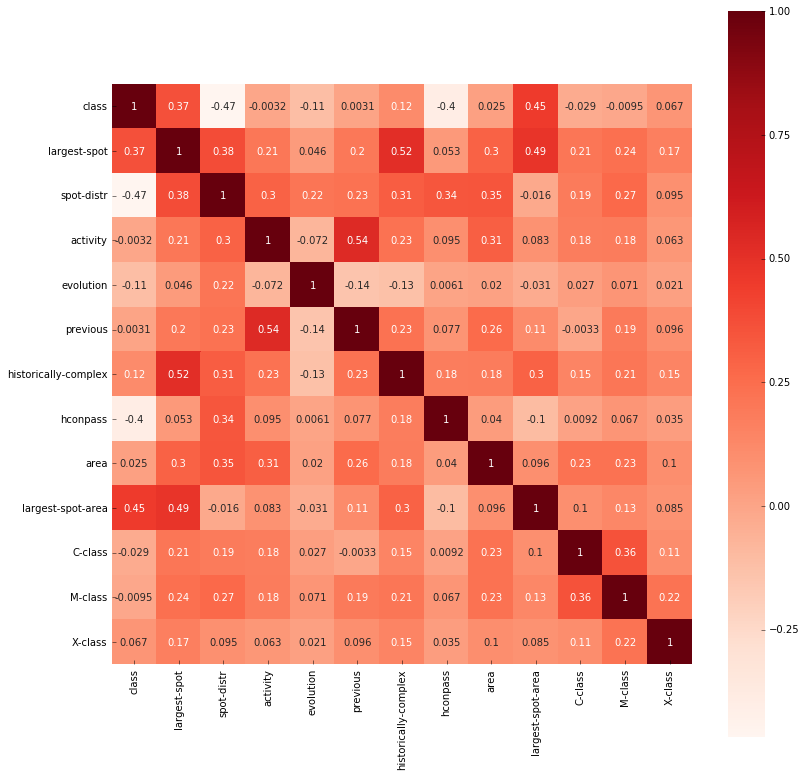

In [24]:
import matplotlib.pyplot as plt

correlation = train_data.corr()
plot = plt.subplots(figsize=(13,13))
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap='Reds')

In [25]:
m_class_traits = ['largest-spot-area', 'area', 'historically-complex', 'activity', 'previous', 'spot-distr', 'largest-spot', 'M-class']
data = train_data[m_class_traits]
test = test_data[m_class_traits]
data.describe()

,largest-spot-area,area,historically-complex,activity,previous,spot-distr,largest-spot,M-class
count,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000
mean,1.755418,1.027864,1.368421,1.139319,1.191950,2.191950,3.182663,0.136223
std,0.430506,0.164838,0.483125,0.346816,0.590029,0.822998,1.599906,0.479409
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,0.000000
75%,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,4.000000,0.000000
max,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,6.000000,4.000000


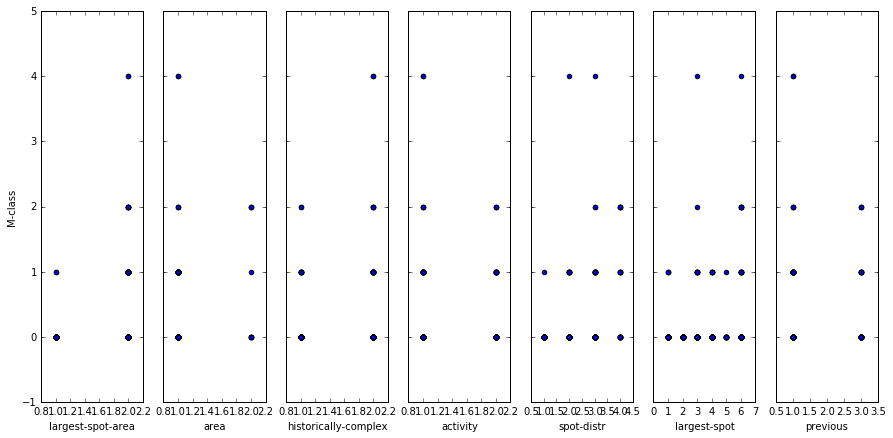

In [26]:
fig, axs = plt.subplots(1, 7, sharey = True)
data.plot(kind = 'scatter', x = 'largest-spot-area', y = 'M-class', ax = axs[0], figsize=(15, 7))
data.plot(kind = 'scatter', x = 'area', y = 'M-class', ax = axs[1])
data.plot(kind = 'scatter', x = 'historically-complex', y = 'M-class', ax = axs[2])
data.plot(kind = 'scatter', x = 'activity', y = 'M-class', ax = axs[3],)
data.plot(kind = 'scatter', x = 'spot-distr', y = 'M-class', ax = axs[4])
data.plot(kind = 'scatter', x = 'largest-spot', y = 'M-class', ax = axs[5])
data.plot(kind = 'scatter', x = 'previous', y = 'M-class', ax = axs[6])

Jak widać nasze dane nie należa do łatwych, ale napewno jest to przypadek realistyczny. Zobaczmy, czy nasz prosta regresja liniowa ma wgl sens przy takich danych.

In [27]:
params = ['largest-spot-area', 'area', 'historically-complex', 'activity', 'previous', 'spot-distr', 'largest-spot']
pred = ['M-class']

# training set
X  = data[params]
Y  = data[pred]

# test set
Xt = test_data[params]
Yt = test_data[pred]

## Klasyczna regresja

In [28]:
lin = linear_model.LinearRegression()
lin.fit(X, Y)
P = lin.predict(Xt)

print("Współczynniki: ", lin.coef_)
print("MSE: %.5f" % metrics.mean_squared_error(Yt, P))

Współczynniki:  [[0.07417493 0.30188544 0.06700434 0.03850862 0.06301361 0.09813218
  0.0163401 ]]
MSE: 0.08917


## Regresja Lasso

In [49]:
lasso = linear_model.Lasso(alpha = 0.02)
lasso.fit(X, Y)

P = lasso.predict(Xt)

print("Współczynniki: ", lasso.coef_)
print("MSE: %.5f" % metrics.mean_squared_error(Yt, P))

Współczynniki:  [0.         0.         0.         0.         0.04716883 0.08921816
 0.04261872]
MSE: 0.09005


In [50]:
lasso = linear_model.Lasso(alpha = 1.0)
lasso.fit(X, Y)

P = lasso.predict(Xt)

print("Współczynniki: ", lasso.coef_)
print("MSE: %.5f" % metrics.mean_squared_error(Yt, P))

Współczynniki:  [0. 0. 0. 0. 0. 0. 0.]
MSE: 0.09959


Zobaczmy jeszcze jak współczynnik alfa

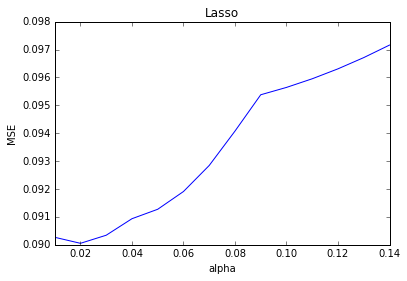

In [30]:
alphas = [x * 0.01 for x in range(1, 15)]
lassos = [metrics.mean_squared_error(linear_model.Lasso(alpha = a).fit(X, Y).predict(Xt), Yt) for a in alphas]
lassos = Series(lassos, index = alphas)
lassos.plot(title = "Lasso")
plt.xlabel("alpha")
plt.ylabel("MSE")

## Regresja Ridge

In [47]:
ridge = linear_model.Ridge(alpha = 0.02)
ridge.fit(X, Y)
P = ridge.predict(Xt)

print("Współczynniki Ridge: ", ridge.coef_)
print("MSE: %.5f" % metrics.mean_squared_error(Yt, P))

Współczynniki Ridge:  [[0.07413758 0.30104776 0.0669767  0.03856676 0.06303218 0.09815707
  0.01636581]]
MSE: 0.08917


In [48]:
ridge = linear_model.Ridge(alpha = 1.0)
ridge.fit(X, Y)
P = ridge.predict(Xt)

print("Współczynniki Ridge: ", ridge.coef_)
print("MSE: %.5f" % metrics.mean_squared_error(Yt, P))

Współczynniki Ridge:  [[0.0723528  0.2651776  0.06572283 0.0409248  0.0638149  0.09915372
  0.01751882]]
MSE: 0.08918


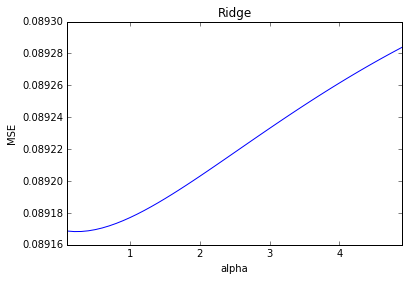

In [32]:
alphas = [x * 0.1 for x in range(1, 50)]
ridges = [metrics.mean_squared_error(linear_model.Ridge(alpha = a).fit(X, Y).predict(Xt), Yt) for a in alphas]
ridges = Series(ridges, index = alphas)
ridges.plot(title = "Ridge")
plt.xlabel("alpha")
plt.ylabel("MSE")

## Regresja ElasticNet

In [46]:
enet = linear_model.ElasticNet(alpha = 1, l1_ratio = 0.5)
enet.fit(X, Y)
P = enet.predict(Xt)

print("Współczynniki: ", enet.coef_)
print("MSE: %.5f" % metrics.mean_squared_error(Yt, P))

Współczynniki:  [0. 0. 0. 0. 0. 0. 0.]
MSE: 0.09959


In [45]:
enet = linear_model.ElasticNet(alpha = 0.0000001, l1_ratio = 0.5)
enet.fit(X, Y)
P = enet.predict(Xt)

print("Współczynniki: ", enet.coef_)
print("MSE: %.5f" % metrics.mean_squared_error(Yt, P))

Współczynniki:  [0.07417459 0.30188281 0.06700413 0.03850846 0.06301368 0.09813224
 0.01634023]
MSE: 0.08917


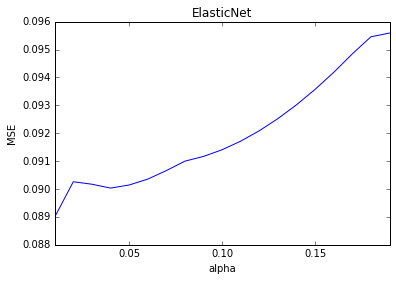

In [38]:
alphas = [x * 0.01 for x in range(1, 20)]
enets = [metrics.mean_squared_error(linear_model.ElasticNet(alpha = a, l1_ratio = 0.5).fit(X, Y).predict(Xt), Yt) for a in alphas]
enets = Series(enets, index = alphas)
enets.plot(title = "ElasticNet")
plt.xlabel("alpha")
plt.ylabel("MSE")

Jak widzimy, klasyczna regresja i regresja Ridge poradziły sobie całkiem ok, biorąc pod uwagę jak wyglądały nasze dane (błąd średniokwadratowy jest dość mały, lecz weźmy pod uwagę, że max wartości przewidywanej to 4), a co więcej dla odcztanego alfa blisko optimum, regresja Ridge dała praktycznie te same współczynniki co regresja klasyczna. 
Regresja Lasso poradziła sobie gorzej mimo wybrania współczynnika alfa optymalnego. 
Regresja ElasticNet ma optimum alfa w zerze, a wtedy degeneruje się do regresji klasycznej. 
Dwie ostatnie regresje dla alfa = 1, wgl nie dopasowują się do danych, zwracając współczynniki równe 0.